In [1]:
import numpy as np
import pymc3 as pm
import matplotlib.pyplot as plt
from scipy.stats import norm


WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Model je preprost

$x_{k+1} = vel*x_{k} + n_k$

$y_k = x_k + m_k$

$n_k$ je state noise

$m_k$ je measurement noise

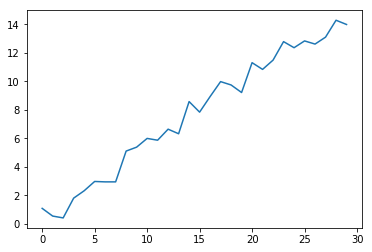

In [2]:
N = 30; 
vel = 0.5
x = 0.1; 
true_positions = np.zeros(N); 
true_positions[0] = x
n = 0.05*norm.rvs(size=N) # State noise



for i in range(1,N):
    x = vel + x + n[i]
    true_positions[i] = x

scale_m_noise = 0.5 # Measurement noise
    
true_positions = true_positions +scale_m_noise*norm.rvs(size=N) 

plt.plot(true_positions)
plt.show()

In [3]:
model = pm.Model()

with model:

    # we're using `some_tau` for the noise throughout the example.
    # this should be replaced with something more meaningful.
    
    BoundedNormal = pm.Bound(pm.Normal, lower=0.0)

    some_tau = BoundedNormal("state_noise_scale", mu=0.1,sd=0.1)
    some_tau_output = BoundedNormal("measurement_noise_scale", mu=0.1,sd=0.1)


    # PRIORS
    # we don't know too much about the velocity, might be pos. or neg. 
    vel = pm.Normal("vel", mu=0, tau=5)

    # MODEL
    # next_state = prev_state + vel (and some gaussian noise)
    # That means that each state depends on the prev_state and the vel.
    # We save the states in a list.
    states = [pm.Normal("s0", mu=true_positions[0], sd=some_tau)]
    for i in range(1, len(true_positions)):
        states.append(pm.Normal(name="s" + str(i),
                                mu=states[-1] + vel,
                                sd=some_tau))

    # observation with gaussian noise
    obs = pm.Normal("obs", mu=states, sd=some_tau_output, observed=true_positions)

In [4]:
Nchain = 1000; 
with model:
#     start = pm.find_MAP()
    step = pm.Slice()
#     trace = pm.sample(Nchain, step=step, start=start, cores=8);
    trace = pm.sample(Nchain, step=step, cores=8);

Multiprocess sampling (8 chains in 8 jobs)
CompoundStep
>Slice: [s29]
>Slice: [s28]
>Slice: [s27]
>Slice: [s26]
>Slice: [s25]
>Slice: [s24]
>Slice: [s23]
>Slice: [s22]
>Slice: [s21]
>Slice: [s20]
>Slice: [s19]
>Slice: [s18]
>Slice: [s17]
>Slice: [s16]
>Slice: [s15]
>Slice: [s14]
>Slice: [s13]
>Slice: [s12]
>Slice: [s11]
>Slice: [s10]
>Slice: [s9]
>Slice: [s8]
>Slice: [s7]
>Slice: [s6]
>Slice: [s5]
>Slice: [s4]
>Slice: [s3]
>Slice: [s2]
>Slice: [s1]
>Slice: [s0]
>Slice: [vel]
>Slice: [measurement_noise_scale]
>Slice: [state_noise_scale]
Sampling 8 chains: 100%|██████████| 12000/12000 [01:00<00:00, 198.38draws/s]
The number of effective samples is smaller than 10% for some parameters.


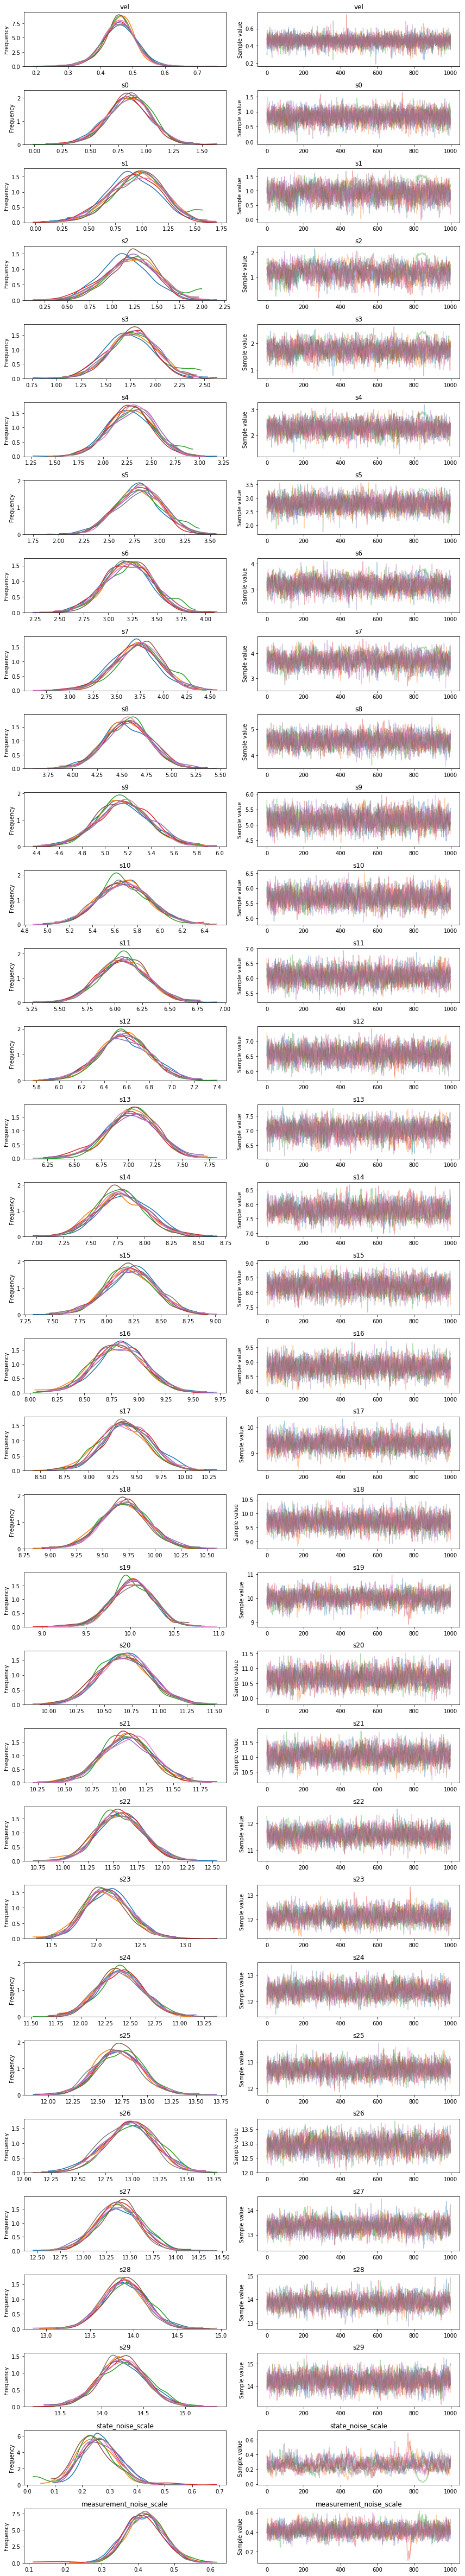

In [5]:
pm.traceplot(trace)
plt.show()

In [8]:
import mpld3

plt.plot(trace['state_noise_scale'])
plt.plot(trace['measurement_noise_scale'])
mpld3.display()

In [13]:
with model:
    mean_field = pm.fit(method='svgd')

100%|██████████| 10000/10000 [01:45<00:00, 94.36it/s]


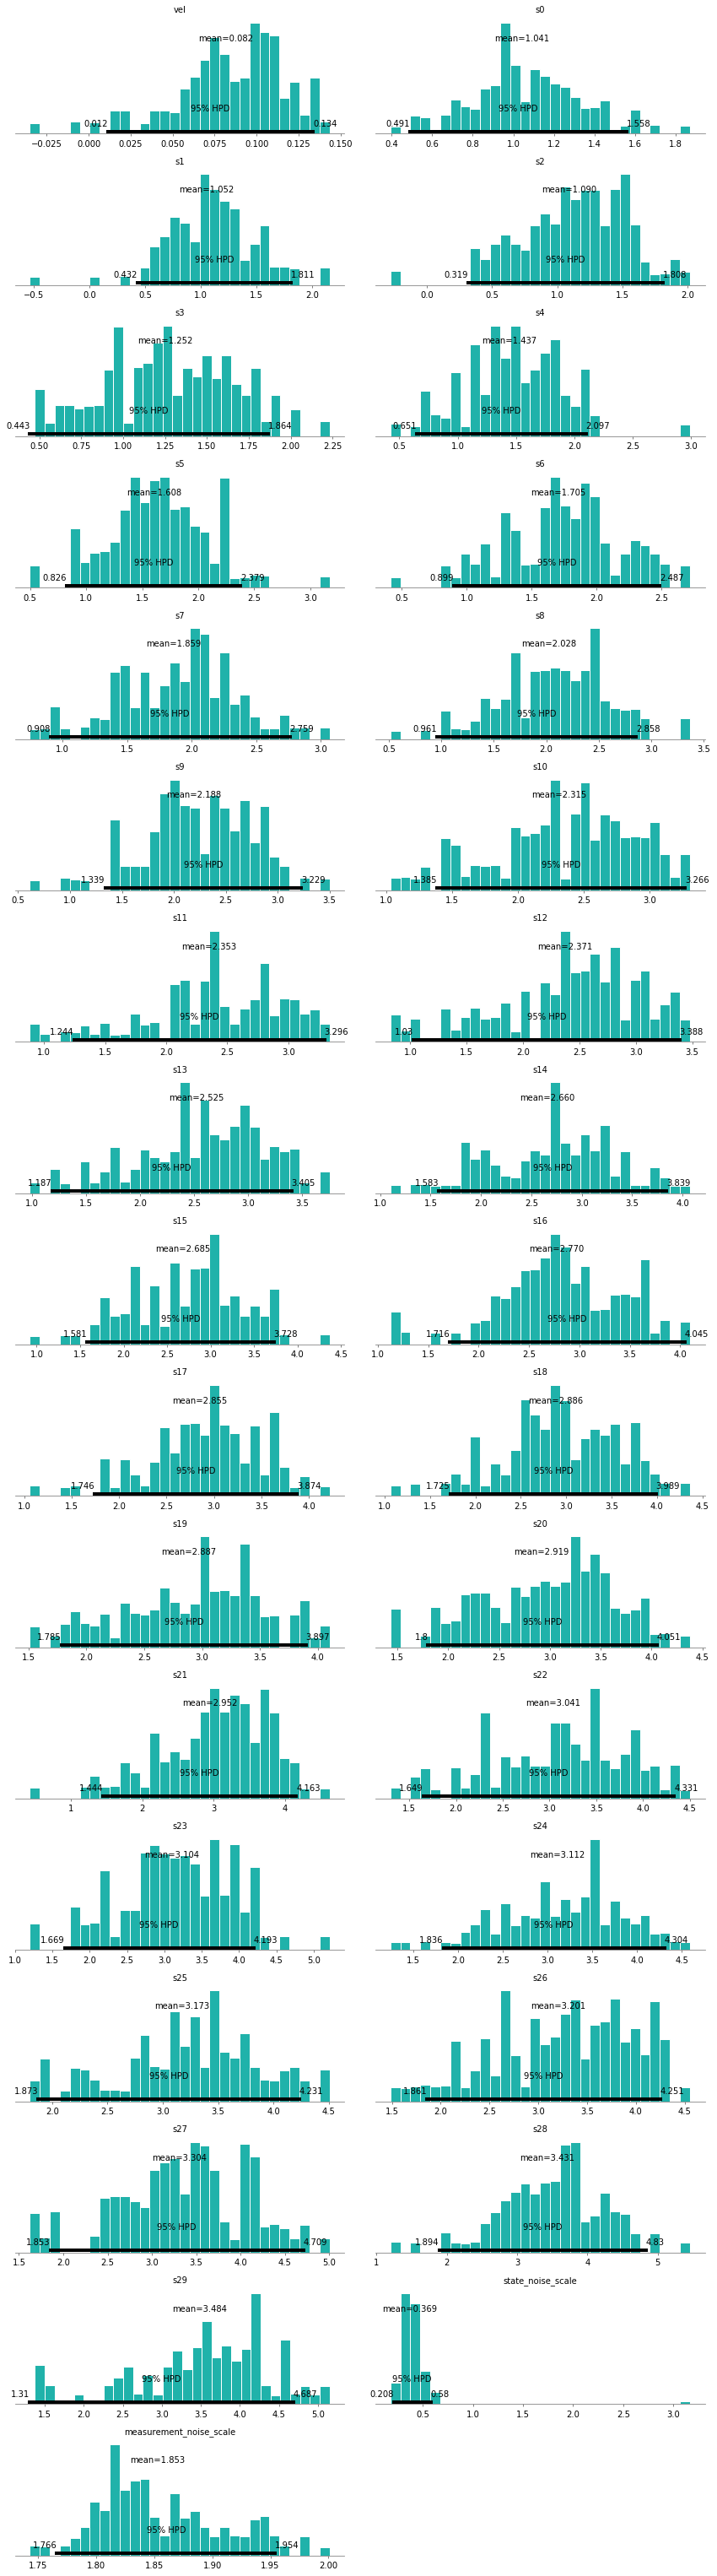

In [14]:
pm.plot_posterior(mean_field.sample(10000), color='LightSeaGreen');
